
Verwendetes Szenario: office
Ladepunkte: 3
Zeitraum: 2025-03-24 00:00:00+01:00 bis 2025-03-28 23:45:00+01:00
Horizont: 5 Tage
Daytypes: {'working_day': 5, 'saturday': 0, 'sunday_holiday': 0}

Sessions
Ankünfte mit Ladebedarf: 37
mit Ladezugang: 19
ohne Ladezugang (drive_off): 18
Alle Fahrzeuge haben Ziel-SoC erreicht.


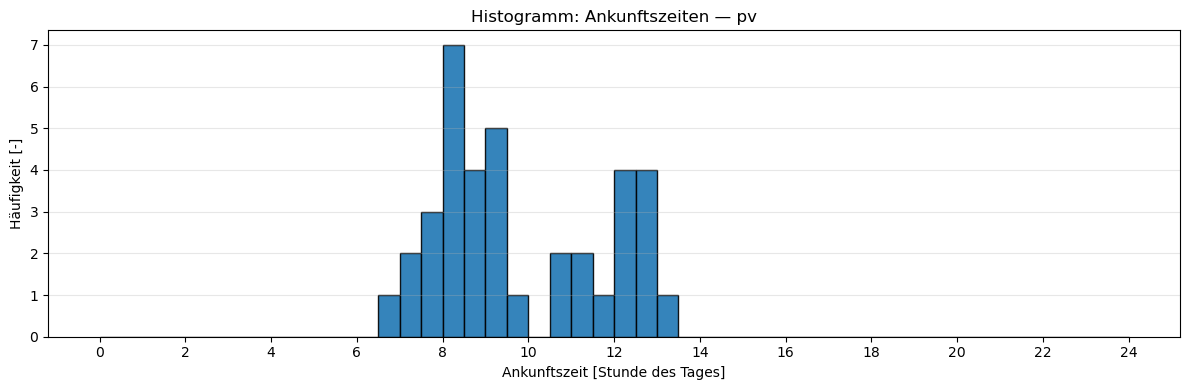

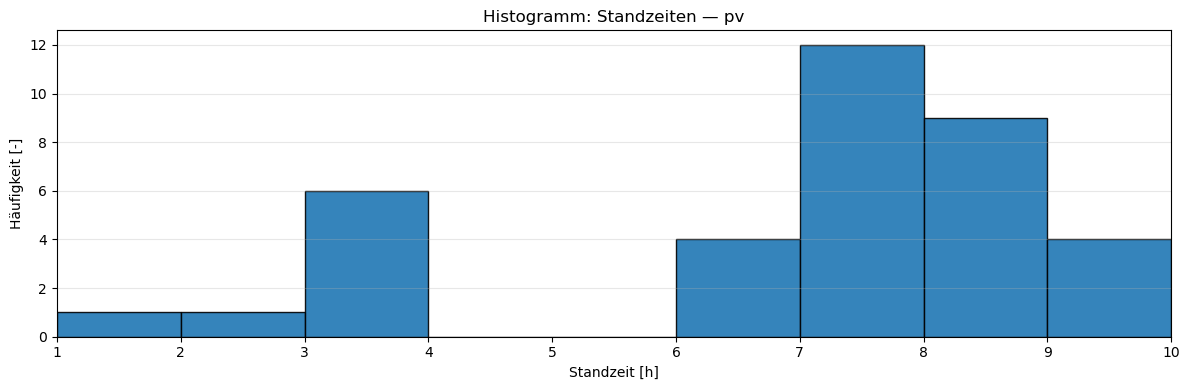

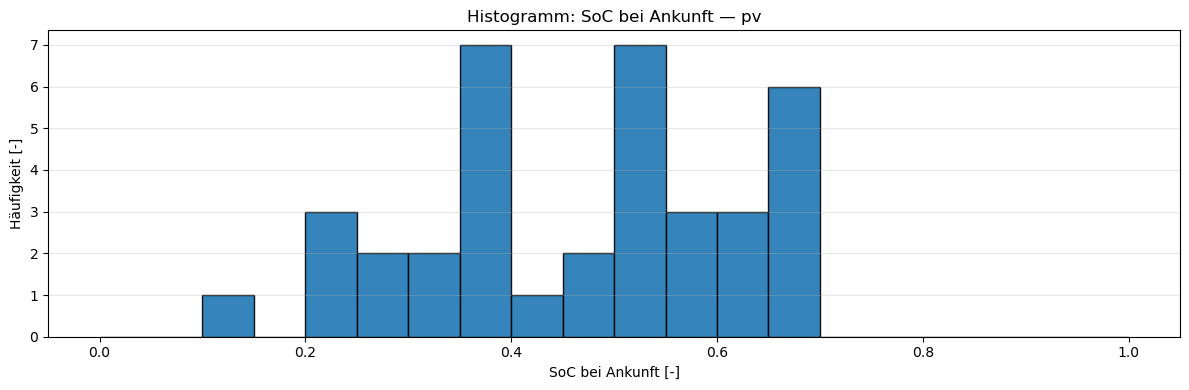

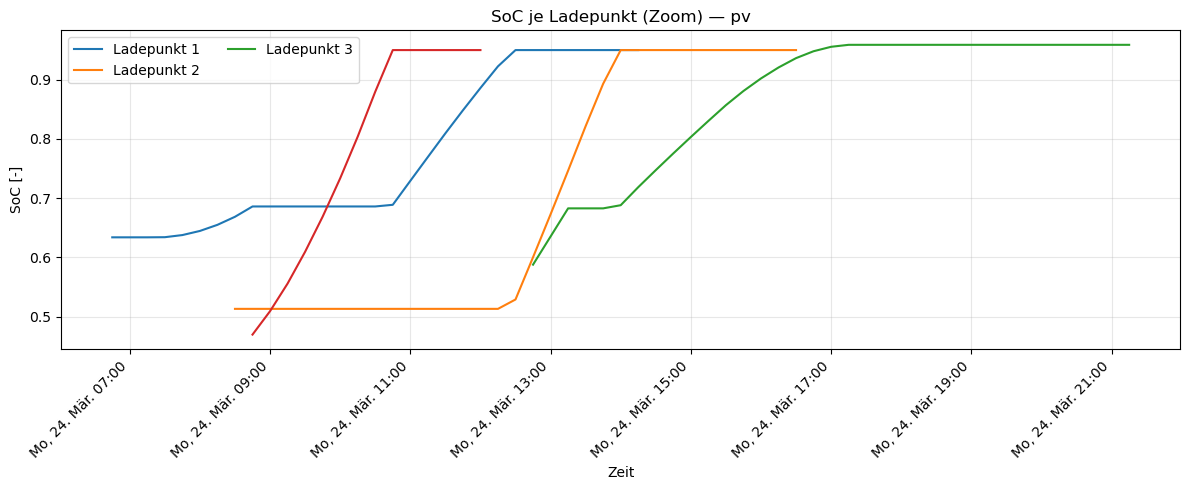

Überschreitungen: 0


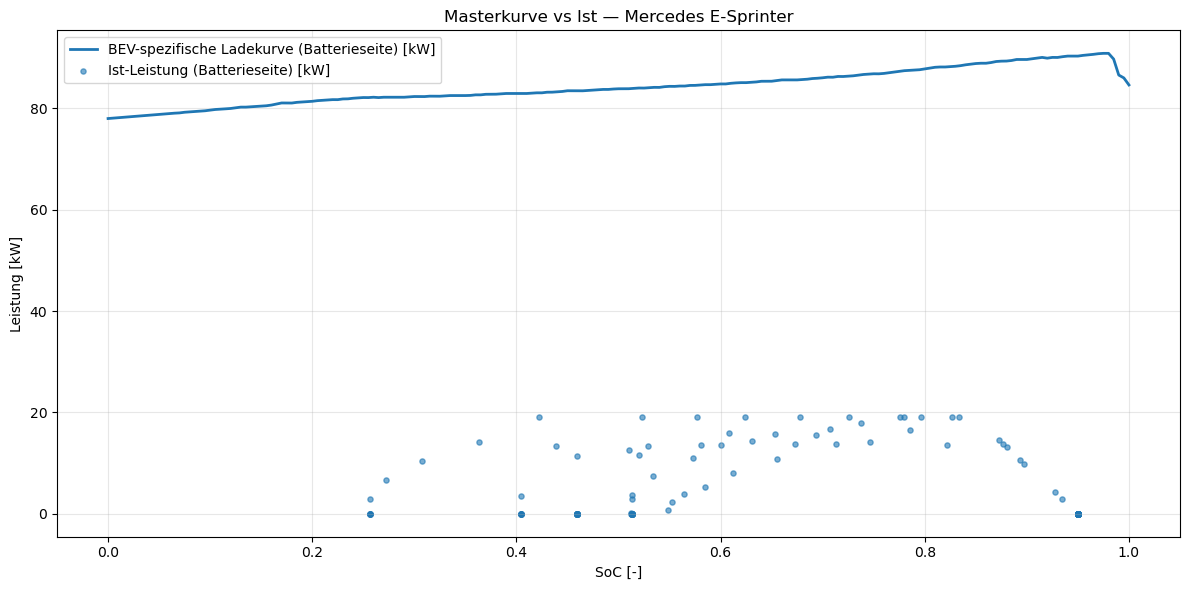

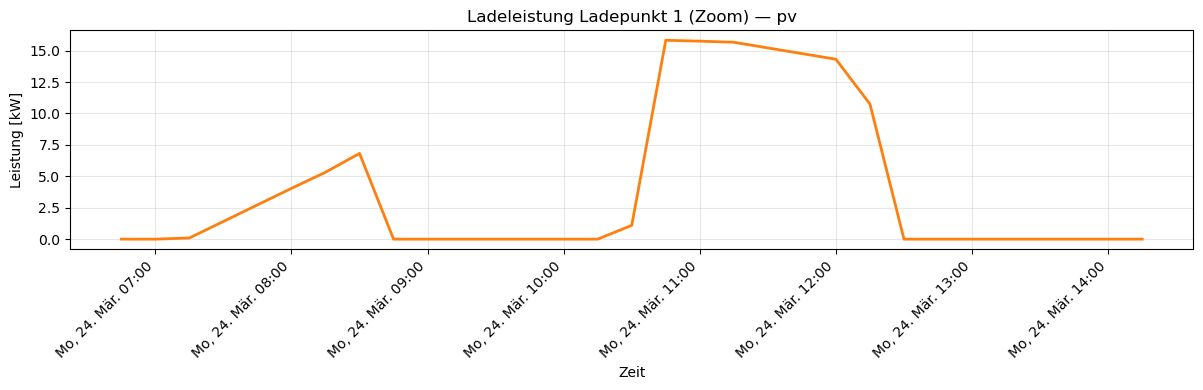

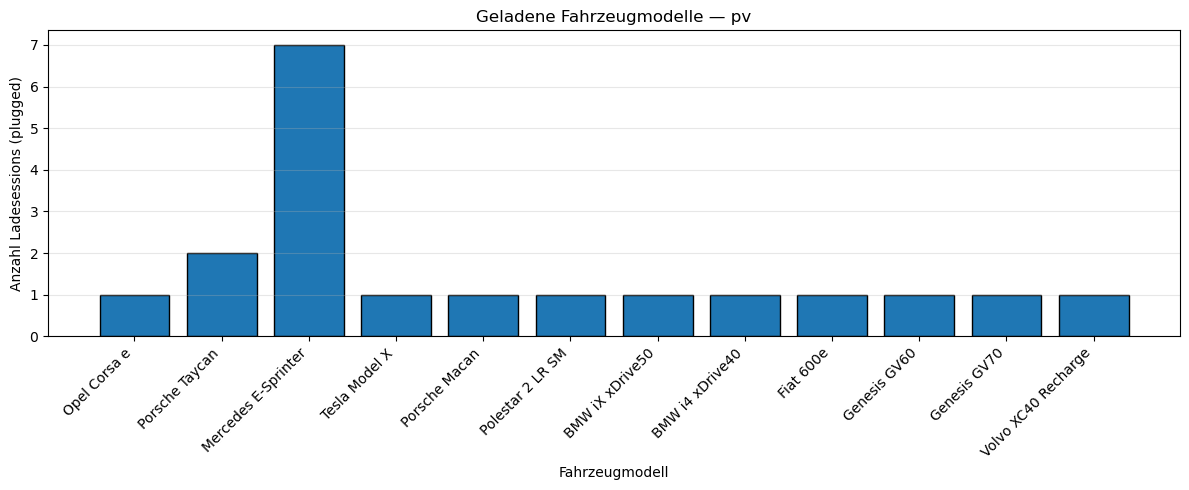

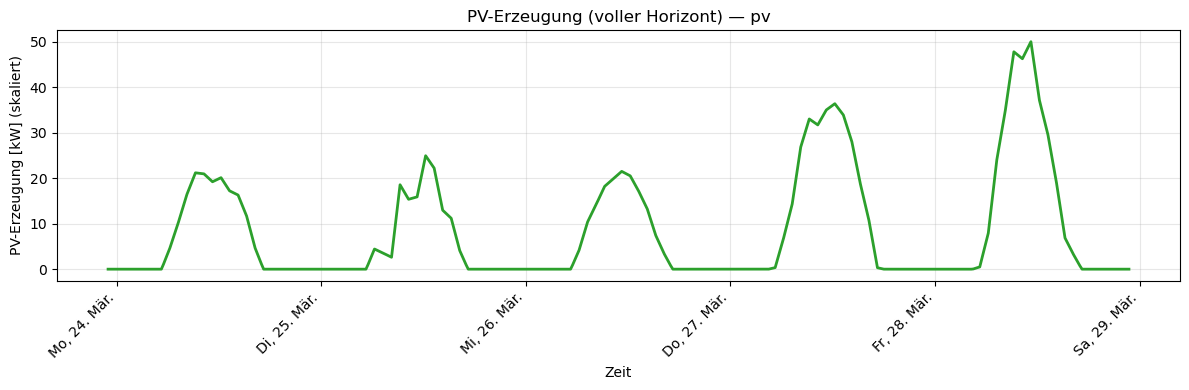

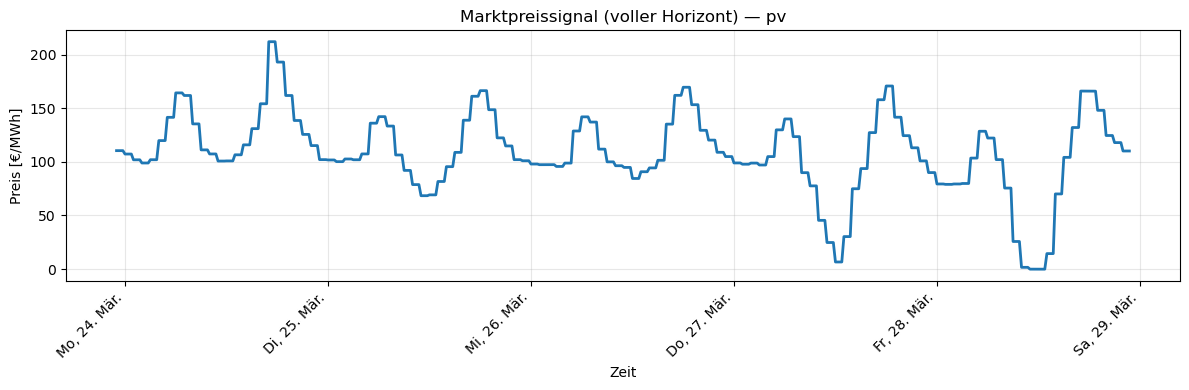

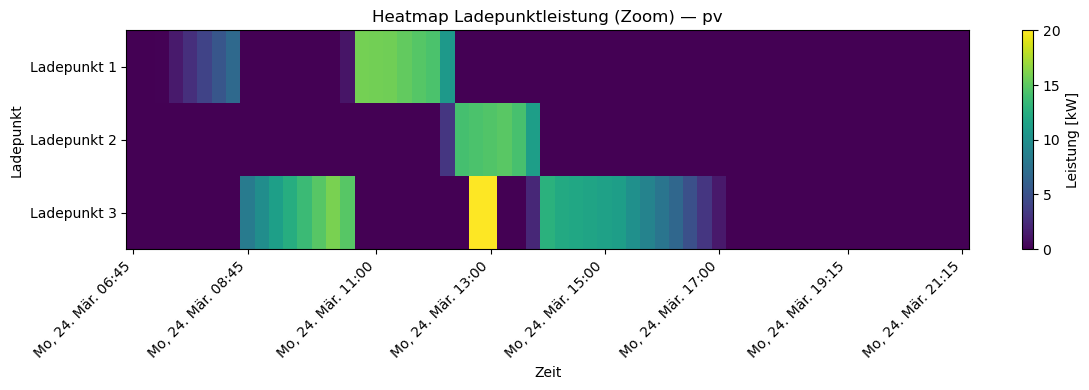

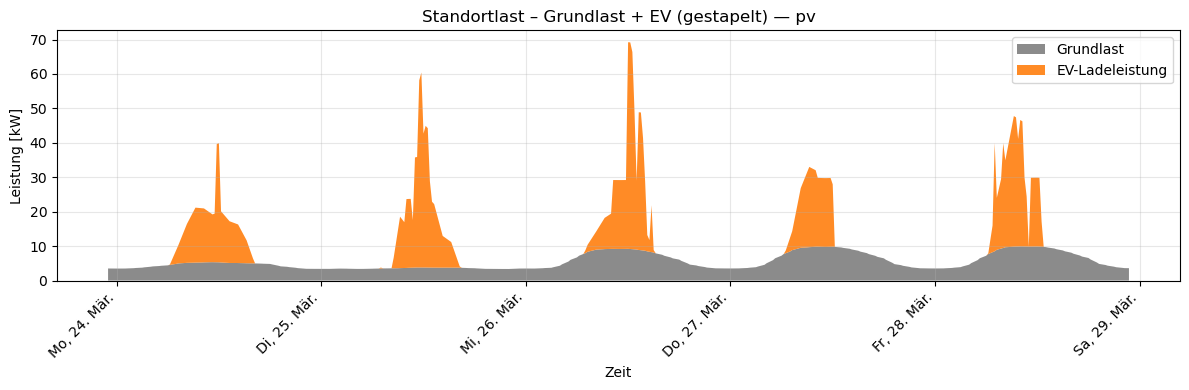

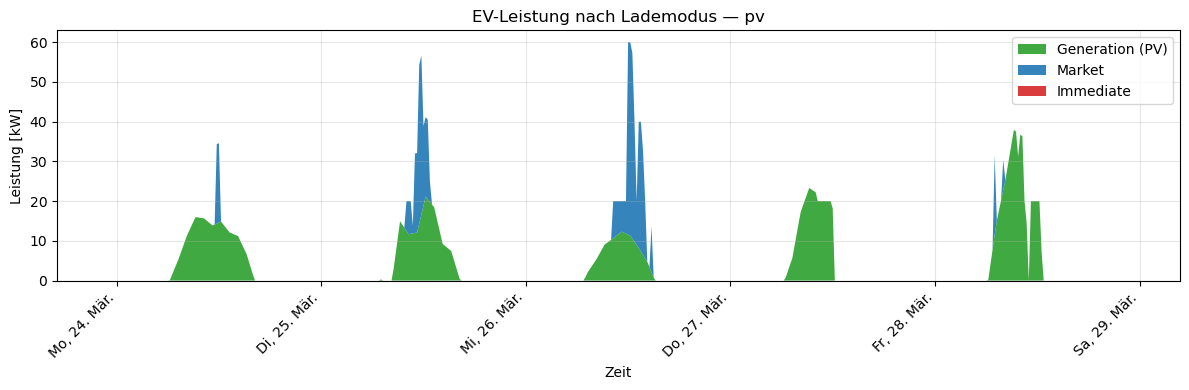

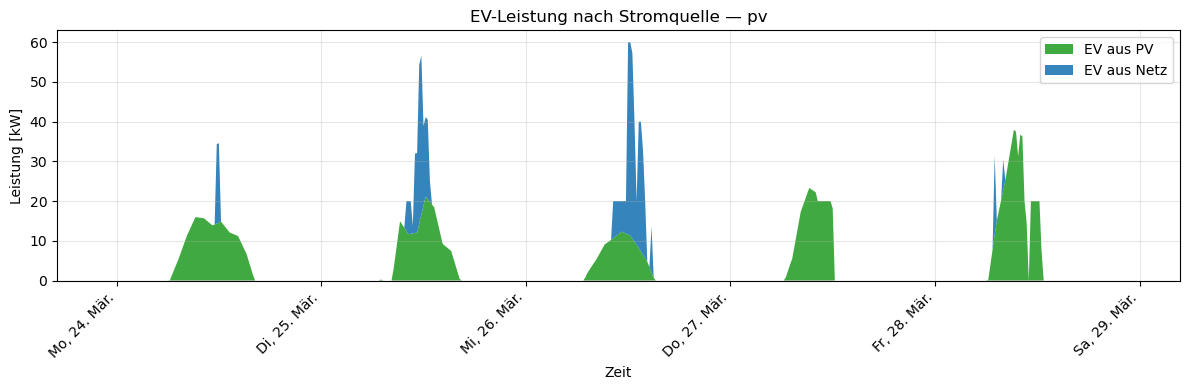

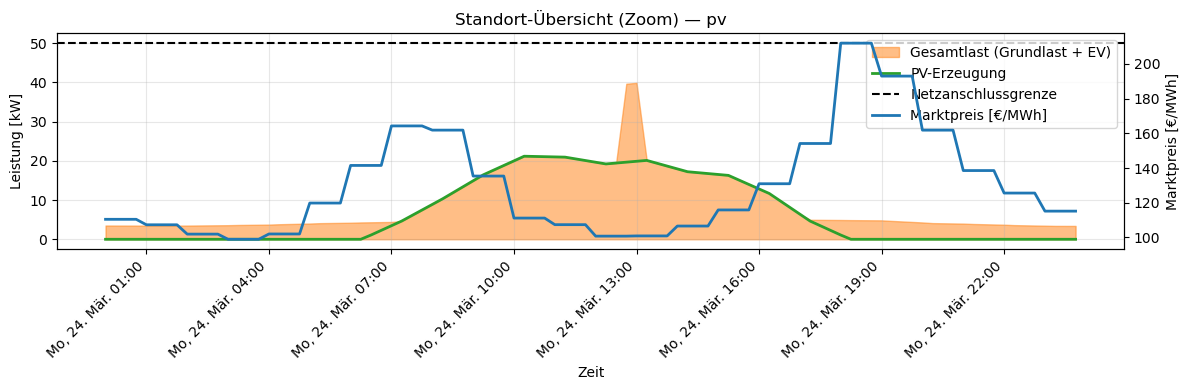

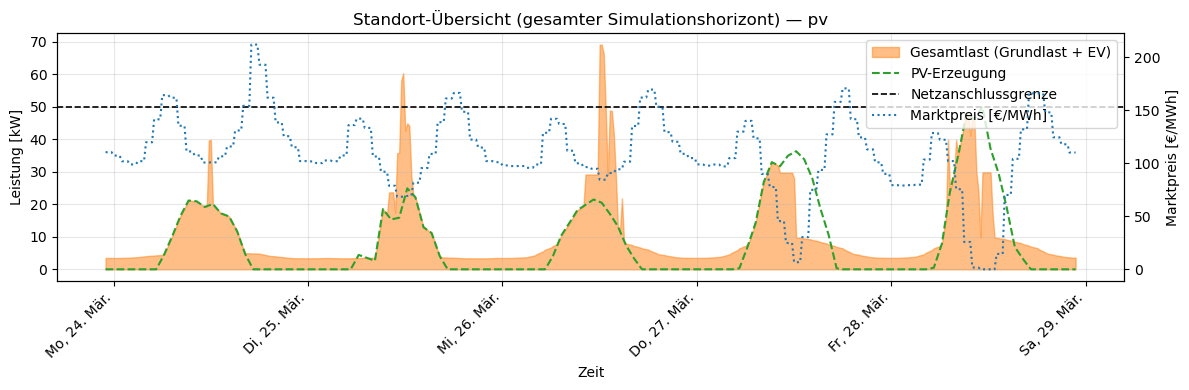

,session_id,charger_id,arrival_time,departure_time,parking_duration_min,soc_arrival,soc_end,charged_site_kwh,charged_pv_site_kwh,charged_market_kwh,remaining_site_kwh,avg_site_kw,avg_pv_kw,avg_grid_kw,avg_market_kw,vehicle_name
0,2025-03-24_000_00003,0,2025-03-24 06:45:00+01:00,2025-03-24 14:30:00+01:00,465.0,0.633926,0.950000,30.942029,30.942029,0.000000,0.000000e+00,3.992520,3.992520,0.000000,0.000000,Porsche Taycan
1,2025-03-24_000_00001,1,2025-03-24 08:30:00+01:00,2025-03-24 16:45:00+01:00,495.0,0.513185,0.950000,21.610849,21.610849,0.000000,0.000000e+00,2.619497,2.619497,0.000000,0.000000,Mercedes E-Sprinter
2,2025-03-24_000_00004,2,2025-03-24 08:45:00+01:00,2025-03-24 12:15:00+01:00,210.0,0.469760,0.950000,25.275786,25.275786,0.000000,0.000000e+00,7.221653,7.221653,0.000000,0.000000,Opel Corsa e
3,2025-03-24_000_00000,2,2025-03-24 12:45:00+01:00,2025-03-24 21:30:00+01:00,525.0,0.587818,0.955539,39.058644,29.058644,10.000000,0.000000e+00,4.463845,3.320988,1.142857,1.142857,Tesla Model X
4,2025-03-25_001_00004,0,2025-03-25 08:00:00+01:00,2025-03-25 17:30:00+01:00,570.0,0.387646,0.955845,62.821698,42.821698,20.000000,0.000000e+00,6.612810,4.507547,2.105263,2.105263,Porsche Macan
5,2025-03-25_001_00001,1,2025-03-25 08:15:00+01:00,2025-03-25 12:00:00+01:00,225.0,0.256551,0.950000,34.307486,27.805454,6.502031,7.105427e-15,9.148663,7.414788,1.733875,1.733875,Mercedes E-Sprinter
6,2025-03-25_001_00007,2,2025-03-25 08:15:00+01:00,2025-03-25 16:00:00+01:00,465.0,0.459416,0.950000,24.271001,24.271001,0.000000,0.000000e+00,3.131742,3.131742,0.000000,0.000000,Mercedes E-Sprinter
7,2025-03-25_001_00002,1,2025-03-25 12:30:00+01:00,2025-03-25 22:00:00+01:00,570.0,0.700000,0.950000,26.315789,0.000000,26.315789,0.000000e+00,2.770083,0.000000,2.770083,2.770083,Polestar 2 LR SM
8,2025-03-26_002_00006,0,2025-03-26 07:15:00+01:00,2025-03-26 13:45:00+01:00,390.0,0.353312,0.950000,69.090161,48.450178,20.639983,1.421085e-14,10.629256,7.453874,3.175382,3.175382,BMW iX xDrive50
9,2025-03-26_002_00000,1,2025-03-26 09:00:00+01:00,2025-03-26 18:00:00+01:00,540.0,0.366369,0.950000,33.174801,0.000000,33.174801,0.000000e+00,3.686089,0.000000,3.686089,3.686089,Fiat 600e


In [1]:
# =============================================================================
# A) Scenario Setup + Notebook-Parameter
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"                                    

zoom_days = 1
random_seed = 43

preview_rows_n = 10             # Anzahl Zeilen in der Plugged-Sessions-Vorschau

# =============================================================================
# B) Imports 
# =============================================================================
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import model.simulation as sim

from collections import Counter
from matplotlib.ticker import FuncFormatter
from IPython.display import display
from zoneinfo import ZoneInfo

warnings.simplefilter("default", UserWarning)

# =============================================================================
# C) Plot Voreinstellungen (semantisch konsistent)
# =============================================================================
COLOR_PV = "#2ca02c"          # grün
COLOR_MARKET = "#1f77b4"      # blau
COLOR_GRID = COLOR_MARKET
COLOR_IMMEDIATE = "#d62728"   # rot
COLOR_SITE_LOAD = "#ff7f0e"   # orange
COLOR_BASELOAD = "#7f7f7f"    # grau
COLOR_TOTAL = "black"
COLOR_GRID_LIMIT = "black"

GERMAN_WEEKDAYS = ["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]
GERMAN_MONTHS = ["Jan.", "Feb.", "Mär.", "Apr.", "Mai", "Jun.", "Jul.", "Aug.", "Sep.", "Okt.", "Nov.", "Dez."]

FIGSIZE_WIDE = (12, 4)
FIGSIZE_MEDIUM = (12, 5)
FIGSIZE_TALL = (12, 6)

# =============================================================================
# D) Notebook Helper Functions
# =============================================================================

def first_existing_column(dataframe: pd.DataFrame, candidates: list[str]) -> str | None:
    """Gibt den ersten vorhandenen Spaltennamen aus einer Kandidatenliste zurück.
    
    Parameter
    ---------
    dataframe:
        DataFrame, in dem die Spalten gesucht werden.
    candidates:
        Kandidaten-Spaltennamen in Prioritätsreihenfolge.
    
    Rückgabe
    --------
    str | None
        Erster Treffer oder None, falls keine Spalte existiert.
    """
    for name in candidates:
        if name in dataframe.columns:
            return name
    return None


def apply_german_time_axis(
    axis,
    timezone: str = "Europe/Berlin",
    show_time: bool = False,
    rotation: int = 45,
    ha: str = "right",
    minticks: int = 4,
    maxticks: int = 10,
):
    """Formatiert die Zeitachse für deutsche Beschriftungen.
    
    - ohne Uhrzeit:  'Mo, 31. Jan.'
    - mit Uhrzeit:   'Mo, 31. Jan. 23:00'
    """
    tzinfo = ZoneInfo(timezone)

    def _fmt(x, pos=None):
        datetime_value = mdates.num2date(x).astimezone(tzinfo)
        weekday_abbreviation = GERMAN_WEEKDAYS[datetime_value.weekday()]
        month_abbreviation = GERMAN_MONTHS[datetime_value.month - 1]
        if show_time:
            return f"{weekday_abbreviation}, {datetime_value.day:02d}. {month_abbreviation} {datetime_value:%H:%M}"
        return f"{weekday_abbreviation}, {datetime_value.day:02d}. {month_abbreviation}"

    axis.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks))
    axis.xaxis.set_major_formatter(FuncFormatter(_fmt))

    for label in axis.get_xticklabels():
        label.set_rotation(rotation)
        label.set_ha(ha)


# =============================================================================
# E) Shortcuts (Builder + Kernfunktionen)
# =============================================================================
load_scenario = sim.read_scenario_from_yaml

build_plugged_sessions_preview_table = sim.build_plugged_sessions_preview_table
summarize_sessions = sim.summarize_sessions

build_power_per_charger_timeseries = sim.build_power_per_charger_timeseries
build_soc_timeseries_by_charger = sim.build_soc_timeseries_by_charger
build_charger_power_heatmap_matrix = sim.build_charger_power_heatmap_matrix
build_ev_power_by_source_timeseries = sim.build_ev_power_by_source_timeseries
build_site_overview_plot_data = sim.build_site_overview_plot_data
build_ev_power_by_mode_timeseries_dataframe = sim.build_ev_power_by_mode_timeseries_dataframe

# =============================================================================
# F) Load scenario + resolve relative paths
# =============================================================================
scenario = sim.read_scenario_from_yaml(scenario_path)
scenario = sim.resolve_paths_relative_to_yaml(scenario, scenario_path)

scenario["time_resolution_min"] = sim.get_time_resolution_min_from_scenario(scenario)
charging_strategy = str(scenario.get("charging_strategy", "immediate")).strip().lower()
strategy_status = charging_strategy 

# =============================================================================
# G) Build timestamps + input time series
# =============================================================================
timestamps = sim.build_simulation_timestamps(scenario)
holiday_dates = sim.get_holiday_dates_from_scenario(scenario, timestamps)

time_resolution_min = int(scenario["time_resolution_min"])
step_hours = float(time_resolution_min) / 60.0

# ggf. aus Szenario oder fix:
timezone = "Europe/Berlin"  # oder scenario.get("timezone")

# --- ALLES aus einer CSV laden + skalieren ---
base_load_kw_per_step, pv_generation_kw_per_step, market_price_eur_per_mwh = (
    sim.read_local_load_pv_market_from_csv(
        csv_path=scenario["localload_pv_market_csv"],
        timestamps=timestamps,
        timezone=timezone,
        base_load_annual_kwh=float(scenario["site"]["base_load_annual_kwh"]),
        pv_system_size_kwp=float(scenario["site"]["pv_system_size_kwp"]),
        profiles_are_normalized=True,
    )
)

# fürs Plotten/DF
pv_generation_series = pv_generation_kw_per_step
market_price_series = market_price_eur_per_mwh
pv_generation_ylabel = "PV [kW/step]"
market_price_ylabel = "Preis [€/MWh]"

vehicle_charging_curves_by_name = sim.read_vehicle_load_profiles_from_csv(
    str(scenario["vehicles"]["vehicle_curve_csv"])
)


# =============================================================================
# H) Sample sessions + run simulation
# =============================================================================
random_generator = np.random.default_rng(int(random_seed))

start_datetime = pd.Timestamp(timestamps[0])

simulation_horizon_days = int(scenario["simulation_horizon_days"])

# Wichtig: start_datetime TZ-sicher aus timestamps nehmen (und auf Tagesstart normalisieren)
start_datetime = pd.Timestamp(timestamps[0]).normalize()

sampled_sessions_all_days = []

for day_index in range(simulation_horizon_days):
    simulation_day_start = start_datetime + pd.DateOffset(days=day_index)  # DST-sicher, tz-aware
    sampled_sessions_for_day = sim.sample_sessions_for_simulation_day(
        scenario=scenario,
        simulation_day_start=simulation_day_start, 
        timestamps=timestamps,
        holiday_dates=holiday_dates,
        vehicle_curves_by_name=vehicle_charging_curves_by_name,
        random_generator=random_generator,
        day_index=day_index,
    )
    sampled_sessions_all_days.extend(sampled_sessions_for_day)


# 1) Simulation (Core)
ev_load_kw, sessions_out, reserved_total_kw, reserved_pv_kw, debug_df = sim.simulate_site_fcfs_with_planning(
    scenario=scenario,
    timestamps=timestamps,
    sessions=sampled_sessions_all_days,
    vehicle_curves_by_name=vehicle_charging_curves_by_name,
    pv_generation_kw_per_step=np.asarray(pv_generation_kw_per_step, dtype=float),
    base_load_kw_per_step=np.asarray(base_load_kw_per_step, dtype=float),
    market_price_eur_per_mwh=np.asarray(market_price_eur_per_mwh, dtype=float),
    record_debug=True,
)

# 3) charger_traces_dataframe bauen (für SoC/Power/Heatmap)
charger_traces_dataframe = sim.build_charger_traces_dataframe(
    sessions_out=sessions_out,
    scenario=scenario,
    vehicle_curves_by_name=vehicle_charging_curves_by_name,
    timestamps=timestamps,
)

# 4) timeseries_dataframe bauen (für Standortplots)
timeseries_dataframe = sim.build_timeseries_dataframe(
    timestamps=timestamps,
    scenario=scenario,
    base_load_kw_per_step=base_load_kw_per_step,
    pv_generation_kw_per_step=pv_generation_kw_per_step,
    ev_load_kw=ev_load_kw,
    market_price_eur_per_mwh=market_price_eur_per_mwh,
    debug_df=debug_df, 
)

# 5) Zoom-Fenster
window_start, window_end = sim.initialize_time_window(
    timestamps=timestamps,
    scenario=scenario,
    days=zoom_days,
)

# optional kompatibel halten
debug_rows = [] if debug_df is None else debug_df.to_dict("records")

site_configuration = scenario["site"]

# =============================================================================
# I) KPIs
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Ladepunkte:", int(site_configuration["number_chargers"]))
print("Zeitraum:", timestamps[0], "bis", timestamps[-1])
print("Horizont:", simulation_horizon_days, "Tage")

daytypes_calendar = sim.get_daytype_calendar(
    start_datetime=start_datetime,
    horizon_days=simulation_horizon_days,
    holiday_dates=holiday_dates,
)

sessions_by_day = sim.group_sessions_by_day(sessions_out, only_plugged=False)
sessions_by_day_plugged = sim.group_sessions_by_day(sessions_out, only_plugged=True)
print("Daytypes:", {k: len(v) for k, v in daytypes_calendar.items()})

summary = summarize_sessions(sessions_out)
print("\nSessions")
print("Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("mit Ladezugang:", summary["num_sessions_plugged"])
print("ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

not_reached_dataframe = pd.DataFrame(summary["not_reached_rows"])

if len(not_reached_dataframe) == 0:
    print("Alle Fahrzeuge haben Ziel-SoC erreicht.")
else:
    # Falls du im Summary schon "remaining_energy_kwh" hast: passt.
    # Falls es mal "remaining_energy" heißen sollte -> zurückbenennen:
    if "remaining_energy" in not_reached_dataframe.columns and "remaining_energy_kwh" not in not_reached_dataframe.columns:
        not_reached_dataframe = not_reached_dataframe.rename(columns={"remaining_energy": "remaining_energy_kwh"})

    # Sortierung
    sort_col = "remaining_energy_kwh" if "remaining_energy_kwh" in not_reached_dataframe.columns else None
    if sort_col is not None:
        not_reached_dataframe = not_reached_dataframe.sort_values(sort_col, ascending=False).reset_index(drop=True)
    else:
        not_reached_dataframe = not_reached_dataframe.reset_index(drop=True)

    # Gewünschte Reihenfolge (nur nehmen, was existiert)
    wanted_cols = [
        "session_id",
        "charger_id",
        "arrival_time",
        "parking_duration_min",
        "soc_arrival",
        "soc_end",
        "remaining_energy_kwh",
    ]
    existing_wanted_cols = [c for c in wanted_cols if c in not_reached_dataframe.columns]
    other_cols = [c for c in not_reached_dataframe.columns if c not in existing_wanted_cols]
    not_reached_dataframe = not_reached_dataframe[existing_wanted_cols + other_cols]

    # vehicle_name sicher entfernen, falls er doch drin ist
    if "vehicle_name" in not_reached_dataframe.columns:
        not_reached_dataframe = not_reached_dataframe.drop(columns=["vehicle_name"])

    print("Ziel-SoC nicht erreicht:", len(not_reached_dataframe))
    display(not_reached_dataframe)


# =============================================================================
# J) PLOTS
# =============================================================================
TZ = str(scenario.get("timezone", "Europe/Berlin"))
tzinfo = ZoneInfo(TZ)

plugged_sessions = [s for s in sessions_out if s.get("status") == "plugged"]
has_charging = len(plugged_sessions) > 0

if not has_charging:
    print("Keine Ladevorgänge im Simulationshorizont")
else:
    # 1) Histogramme der Eingangsdaten
    only_plugged = False
    _sessions = plugged_sessions if only_plugged else list(sessions_out)

    # 1a) Ankunftszeiten (Uhrzeit im Tagesverlauf)
    arrival_series = pd.to_datetime(pd.Series([s.get("arrival_time") for s in _sessions]), errors="coerce").dropna()
    if not arrival_series.empty:
        arrival_local = (
            arrival_series.dt.tz_convert(tzinfo)
            if arrival_series.dt.tz is not None
            else arrival_series.dt.tz_localize(tzinfo)
        )
        arrival_hour = arrival_local.dt.hour + arrival_local.dt.minute / 60.0

        plt.figure(figsize=FIGSIZE_WIDE)
        plt.hist(arrival_hour, bins=np.arange(0, 24.5, 0.5), edgecolor="black", alpha=0.9)
        plt.xlabel("Ankunftszeit [Stunde des Tages]")
        plt.ylabel("Häufigkeit [-]")
        plt.title(sim.decorate_title_with_status("Histogramm: Ankunftszeiten", charging_strategy, strategy_status))
        plt.grid(True, axis="y", alpha=0.3)
        plt.xticks(range(0, 25, 2))
        plt.tight_layout()
        plt.show()

    # 1b) Standzeiten (Parkdauer)
    temporary_dataframe = pd.DataFrame({
        "arrival": pd.to_datetime(pd.Series([s.get("arrival_time") for s in _sessions]), errors="coerce"),
        "departure": pd.to_datetime(pd.Series([s.get("departure_time") for s in _sessions]), errors="coerce"),
    }).dropna()

    if not temporary_dataframe.empty:
        if temporary_dataframe["arrival"].dt.tz is None:
            temporary_dataframe["arrival"] = temporary_dataframe["arrival"].dt.tz_localize(tzinfo)
        if temporary_dataframe["departure"].dt.tz is None:
            temporary_dataframe["departure"] = temporary_dataframe["departure"].dt.tz_localize(tzinfo)

        temporary_dataframe["parking_duration_h"] = (temporary_dataframe["departure"] - temporary_dataframe["arrival"]).dt.total_seconds() / 3600.0
        dur_h = temporary_dataframe["parking_duration_h"].to_numpy(dtype=float)
        dur_h = dur_h[np.isfinite(dur_h) & (dur_h >= 0)]

        if dur_h.size > 0:
            dur_min = dur_h * 60.0
            use_minutes = float(dur_h.max()) <= 4.0

            if use_minutes:
                x = dur_min
                xlabel = "Standzeit [min]"
                span = float(x.max() - x.min())
                tick_step = 10 if span <= 180 else (30 if span <= 360 else 60)
                bin_width = tick_step
            else:
                x = dur_h
                xlabel = "Standzeit [h]"
                span = float(x.max() - x.min())
                bin_width = 0.5 if span <= 6 else 1.0
                full_hours_range = float(np.ceil(x.max()) - np.floor(x.min()))
                tick_step = 1 if full_hours_range <= 12 else 2

            start_tick = float(np.floor(x.min() / tick_step) * tick_step)
            end_tick = float(np.ceil(x.max() / tick_step) * tick_step)
            bins = np.arange(start_tick, end_tick + bin_width, bin_width)
            if bins.size < 2:
                bins = 10

            plt.figure(figsize=FIGSIZE_WIDE)
            plt.hist(x, bins=bins, edgecolor="black", alpha=0.9)
            plt.xlabel(xlabel)
            plt.ylabel("Häufigkeit [-]")
            plt.title(sim.decorate_title_with_status("Histogramm: Standzeiten", charging_strategy, strategy_status))
            plt.grid(True, axis="y", alpha=0.3)
            ticks = np.arange(start_tick, end_tick + 0.5 * tick_step, tick_step)
            if use_minutes:
                ticks = ticks.astype(int)
            plt.xticks(ticks)
            plt.xlim(start_tick, end_tick)
            plt.tight_layout()
            plt.show()

    # 1c) SoC bei Ankunft
    soc_arrival = pd.to_numeric(
        pd.Series([s.get("state_of_charge_at_arrival", np.nan) for s in _sessions]),
        errors="coerce",
    ).dropna()
    soc_arrival = soc_arrival[(soc_arrival >= 0.0) & (soc_arrival <= 1.0)]

    if not soc_arrival.empty:
        plt.figure(figsize=FIGSIZE_WIDE)
        plt.hist(soc_arrival, bins=np.linspace(0, 1, 21), edgecolor="black", alpha=0.9)
        plt.xlabel("SoC bei Ankunft [-]")
        plt.ylabel("Häufigkeit [-]")
        plt.title(sim.decorate_title_with_status("Histogramm: SoC bei Ankunft", charging_strategy, strategy_status))
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 2) SoC je Ladepunkt (Zoom)
    soc_by_charger_id = build_soc_timeseries_by_charger(
        charger_traces_dataframe=charger_traces_dataframe,
        charger_ids=list(range(int(site_configuration["number_chargers"]))),
        start=window_start,
        end=window_end,
    )

    if any(dataframe is not None and len(dataframe) > 0 and {"timestamp", "soc"}.issubset(dataframe.columns) for dataframe in soc_by_charger_id.values()):
        plt.figure(figsize=FIGSIZE_MEDIUM)

        for charger_id, soc_dataframe in soc_by_charger_id.items():
            if soc_dataframe is None or len(soc_dataframe) == 0 or not {"timestamp", "soc"}.issubset(soc_dataframe.columns):
                continue

            if "session_id" not in soc_dataframe.columns:
                plt.plot(soc_dataframe["timestamp"], soc_dataframe["soc"], linewidth=1.5, label=f"Ladepunkt {charger_id + 1}")
                continue

            soc_dataframe = soc_dataframe.sort_values("timestamp")
            first_segment = True
            for _, segment in soc_dataframe.groupby("session_id"):
                if len(segment) < 2:
                    continue
                plt.plot(
                    segment["timestamp"],
                    segment["soc"],
                    linewidth=1.5,
                    label=f"Ladepunkt {charger_id + 1}" if first_segment else None,
                )
                first_segment = False

        plt.xlabel("Zeit")
        plt.ylabel("SoC [-]")
        plt.title(sim.decorate_title_with_status("SoC je Ladepunkt (Zoom)", charging_strategy, strategy_status))
        plt.grid(True, alpha=0.3)
        plt.legend(loc="upper left", ncols=2)
        apply_german_time_axis(plt.gca(), timezone=TZ, show_time=True)
        plt.tight_layout()
        plt.show()

    # 3) Kurvenvalidierung
    most_used_vehicle_name = sim.get_most_used_vehicle_name(
        sessions_out=sessions_out,
        charger_traces_dataframe=charger_traces_dataframe,
        only_plugged_sessions=True,
    )
    curve = vehicle_charging_curves_by_name.get(most_used_vehicle_name) if most_used_vehicle_name else None

    if curve is not None:
        plot_data = sim.build_master_curve_and_actual_points_for_vehicle(
            charger_traces_dataframe=charger_traces_dataframe,
            scenario=scenario,
            curve=curve,
        )

        print("Überschreitungen:", plot_data["number_violations"])  # optional, falls du es behalten willst

        plt.figure(figsize=FIGSIZE_TALL)
        plt.plot(plot_data["master_soc"], plot_data["master_power_battery_kw"], linewidth=2,
                 label="BEV-spezifische Ladekurve (Batterieseite) [kW]")
        plt.scatter(plot_data["actual_soc"], plot_data["actual_power_batt_kw"], s=14, alpha=0.6,
                    label="Ist-Leistung (Batterieseite) [kW]")

        if plot_data["number_violations"] > 0:
            mask = plot_data["violation_mask"]
            plt.scatter(plot_data["actual_soc"][mask], plot_data["actual_power_batt_kw"][mask],
                        s=30, alpha=0.9, color="red",
                        label=f"Überschreitungen (n={plot_data['number_violations']})")

        plt.xlabel("SoC [-]")
        plt.ylabel("Leistung [kW]")
        plt.title(f"Masterkurve vs Ist — {plot_data['vehicle_name']}")
        plt.grid(True, alpha=0.3)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.show()

    # 4) Leistung eines Ladepunkts (Zoom)
    charger_id_to_plot = 0
    charger_label = charger_id_to_plot + 1

    dataframe = build_power_per_charger_timeseries(
        charger_traces_dataframe,
        charger_id=charger_id_to_plot,
        start=window_start,
        end=window_end,
    )

    if dataframe is not None and not dataframe.empty:
        time_values = dataframe["timestamp"] if "timestamp" in dataframe.columns else (dataframe.index if isinstance(dataframe.index, pd.DatetimeIndex) else None)
        power_values = dataframe["power_kw"] if "power_kw" in dataframe.columns else None
        if time_values is not None and power_values is not None:
            plt.figure(figsize=FIGSIZE_WIDE)
            plt.plot(time_values, power_values, color=COLOR_SITE_LOAD, linewidth=2)
            plt.xlabel("Zeit")
            plt.ylabel("Leistung [kW]")
            plt.title(sim.decorate_title_with_status(f"Ladeleistung Ladepunkt {charger_label} (Zoom)", charging_strategy, strategy_status))
            plt.grid(True, alpha=0.3)
            apply_german_time_axis(plt.gca(), timezone=TZ, show_time=True)
            plt.tight_layout()
            plt.show()

    # 5) Fahrzeugzählung (plugged Sessions)
    vehicle_counts = Counter(s.get("vehicle_name", "") for s in plugged_sessions)
    if vehicle_counts:
        plt.figure(figsize=FIGSIZE_MEDIUM)
        plt.bar(list(vehicle_counts.keys()), list(vehicle_counts.values()), edgecolor="black")
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Fahrzeugmodell")
        plt.ylabel("Anzahl Ladesessions (plugged)")
        plt.title(sim.decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 6) PV-Erzeugung (voller Horizont)
    if "pv_generation_kw" in timeseries_dataframe.columns and timeseries_dataframe["pv_generation_kw"].notna().any():
        plt.figure(figsize=FIGSIZE_WIDE)
        plt.plot(timeseries_dataframe["timestamp"], timeseries_dataframe["pv_generation_kw"], linewidth=2, color=COLOR_PV)
        plt.xlabel("Zeit")
        plt.ylabel("PV-Erzeugung [kW] (skaliert)")
        plt.title(sim.decorate_title_with_status("PV-Erzeugung (voller Horizont)", charging_strategy, strategy_status))
        plt.grid(True, alpha=0.3)
        apply_german_time_axis(plt.gca(), timezone=TZ, show_time=False)
        plt.tight_layout()
        plt.show()

    # 7) Marktpreissignal (voller Horizont)
    if market_price_series is not None and market_price_ylabel is not None:
        plt.figure(figsize=FIGSIZE_WIDE)
        plt.plot(timestamps, market_price_series, linewidth=2, color=COLOR_MARKET)
        plt.xlabel("Zeit")
        plt.ylabel(market_price_ylabel)
        plt.title(sim.decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
        plt.grid(True, alpha=0.3)
        apply_german_time_axis(plt.gca(), timezone=TZ, show_time=False)
        plt.tight_layout()
        plt.show()

    # 8) Heatmap (Zoom)
    heatmap = build_charger_power_heatmap_matrix(
        charger_traces_dataframe,
        start=window_start,
        end=window_end,
    )

    ts_raw = heatmap.get("timestamps", []) if isinstance(heatmap, dict) else []
    if ts_raw:
        ts_list = pd.to_datetime(list(ts_raw))
        n = len(ts_list)
        if n > 0:
            figure, axis = plt.subplots(figsize=FIGSIZE_WIDE)
            im = axis.imshow(heatmap["matrix"], aspect="auto", interpolation="nearest")
            figure.colorbar(im, ax=axis, label="Leistung [kW]")

            axis.set_yticks(np.arange(len(heatmap["charger_ids"])))
            axis.set_yticklabels([f"Ladepunkt {int(i) + 1}" for i in heatmap["charger_ids"]])

            tick_idx = np.unique(np.linspace(0, n - 1, num=min(8, n)).round().astype(int))

            def _fmt_dt(datetime_value):
                weekday_abbreviation = GERMAN_WEEKDAYS[datetime_value.weekday()]
                month_abbreviation = GERMAN_MONTHS[datetime_value.month - 1]
                return f"{weekday_abbreviation}, {datetime_value.day:02d}. {month_abbreviation} {datetime_value:%H:%M}"

            axis.set_xticks(tick_idx)                
            axis.set_xticklabels([_fmt_dt(ts_list[i]) for i in tick_idx], rotation=45, ha="right")

            axis.set_title(sim.decorate_title_with_status("Heatmap Ladepunktleistung (Zoom)", charging_strategy, strategy_status))
            axis.set_xlabel("Zeit")
            axis.set_ylabel("Ladepunkt")
            figure.tight_layout()
            plt.show()

    # 9) Standortlast gestapelt (voller Horizont)
    plt.figure(figsize=FIGSIZE_WIDE)
    plt.stackplot(
        timeseries_dataframe["timestamp"],
        timeseries_dataframe["base_load_kw"].astype(float).fillna(0.0),
        timeseries_dataframe["ev_load_kw"].astype(float).fillna(0.0),
        labels=["Grundlast", "EV-Ladeleistung"],
        colors=[COLOR_BASELOAD, COLOR_SITE_LOAD],
        alpha=0.9,
    )
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [kW]")
    plt.title(sim.decorate_title_with_status("Standortlast – Grundlast + EV (gestapelt)", charging_strategy, strategy_status))
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    apply_german_time_axis(plt.gca(), timezone=TZ, show_time=False)
    plt.tight_layout()
    plt.show()

    # 10) EV-Leistung nach Modus
    mode_dataframe = build_ev_power_by_mode_timeseries_dataframe(
        timeseries_dataframe=timeseries_dataframe,
        sessions_out=sessions_out,
        scenario=scenario,
    )
    if mode_dataframe is not None and not mode_dataframe.empty and {"timestamp","ev_generation_kw","ev_market_kw","ev_immediate_kw"}.issubset(mode_dataframe.columns):
        plt.figure(figsize=FIGSIZE_WIDE)
        plt.stackplot(
            mode_dataframe["timestamp"],
            mode_dataframe["ev_generation_kw"],
            mode_dataframe["ev_market_kw"],
            mode_dataframe["ev_immediate_kw"],
            labels=["Generation (PV)", "Market", "Immediate"],
            colors=[COLOR_PV, COLOR_MARKET, COLOR_IMMEDIATE],
            alpha=0.9,
        )
        plt.xlabel("Zeit")
        plt.ylabel("Leistung [kW]")
        plt.title(sim.decorate_title_with_status("EV-Leistung nach Lademodus", charging_strategy, strategy_status))
        plt.legend(loc="upper right")
        plt.grid(True, alpha=0.3)
        apply_german_time_axis(plt.gca(), timezone=TZ, show_time=False)
        plt.tight_layout()
        plt.show()

    # 11) EV-Leistung nach Quelle
    ev_power_by_source_dataframe = build_ev_power_by_source_timeseries(timeseries_dataframe)
    if ev_power_by_source_dataframe is not None and not ev_power_by_source_dataframe.empty and {"timestamp","ev_from_pv_kw","ev_from_grid_kw"}.issubset(ev_power_by_source_dataframe.columns):
        plt.figure(figsize=FIGSIZE_WIDE)
        plt.stackplot(
            ev_power_by_source_dataframe["timestamp"],
            ev_power_by_source_dataframe["ev_from_pv_kw"],
            ev_power_by_source_dataframe["ev_from_grid_kw"],
            labels=["EV aus PV", "EV aus Netz"],
            colors=[COLOR_PV, COLOR_GRID],
            alpha=0.9,
        )
        plt.xlabel("Zeit")
        plt.ylabel("Leistung [kW]")
        plt.title(sim.decorate_title_with_status("EV-Leistung nach Stromquelle", charging_strategy, strategy_status))
        plt.legend(loc="upper right")
        plt.grid(True, alpha=0.3)
        apply_german_time_axis(plt.gca(), timezone=TZ, show_time=False)
        plt.tight_layout()
        plt.show()


# 12a) Standort-Übersicht (Zoom) – Fläche + PV + Marktpreis
site_overview_data = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=window_start,
    end=window_end,
)

overview_dataframe = site_overview_data["dataframe"]
total_load_kw = site_overview_data["total_load_kw"]
pv_generation_kw = site_overview_data["pv_generation_kw"]
grid_limit_kw = site_overview_data["grid_limit_kw"]

market_price_column = first_existing_column(
    overview_dataframe,
    ["market_price_eur_per_mwh", "market_price", "price_eur_per_mwh"],
)

figure, ax_load = plt.subplots(figsize=FIGSIZE_WIDE)

ax_load.fill_between(
    overview_dataframe["timestamp"],
    total_load_kw,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

if pv_generation_kw is not None:
    ax_load.plot(
        overview_dataframe["timestamp"],
        pv_generation_kw,
        color=COLOR_PV,
        linestyle="-",
        linewidth=2,
        label="PV-Erzeugung",
    )

ax_load.axhline(
    grid_limit_kw,
    linestyle="--",
    linewidth=1.5,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

# rechte Achse nur für Preis
ax_price = None
if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe["timestamp"],
        overview_dataframe[market_price_column],
        linestyle="-",
        linewidth=2,
        color=COLOR_MARKET,
        label="Marktpreis [€/MWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/MWh]")

# Legende zusammenführen
lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2
ax_load.legend(lines, labels, loc="upper right")

ax_load.set_title(sim.decorate_title_with_status("Standort-Übersicht (Zoom)", charging_strategy, strategy_status))
apply_german_time_axis(ax_load, timezone=TZ, show_time=True)
figure.tight_layout()
plt.show()


# 12b) Standort-Übersicht (gesamter Simulationshorizont)
site_overview_data_full = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=None,
    end=None,
)

overview_dataframe_full = site_overview_data_full["dataframe"]
total_load_kw_full = site_overview_data_full["total_load_kw"]
pv_generation_kw_full = site_overview_data_full["pv_generation_kw"]
grid_limit_kw_full = site_overview_data_full["grid_limit_kw"]

market_price_column = first_existing_column(
    overview_dataframe_full,
    ["market_price_eur_per_mwh", "market_price", "price_eur_per_mwh"],
)

figure, ax_load = plt.subplots(figsize=FIGSIZE_WIDE)

ax_load.fill_between(
    overview_dataframe_full["timestamp"],
    total_load_kw_full,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

if pv_generation_kw_full is not None:
    ax_load.plot(
        overview_dataframe_full["timestamp"],
        pv_generation_kw_full,
        color=COLOR_PV,
        linestyle="--",
        linewidth=1.5,
        label="PV-Erzeugung",
    )

ax_load.axhline(
    grid_limit_kw_full,
    linestyle="--",
    linewidth=1.2,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

ax_price = None
if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe_full["timestamp"],
        overview_dataframe_full[market_price_column],
        linestyle=":",
        linewidth=1.5,
        color=COLOR_MARKET,
        label="Marktpreis [€/MWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/MWh]")

lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2
ax_load.legend(lines, labels, loc="upper right")

ax_load.set_title(sim.decorate_title_with_status("Standort-Übersicht (gesamter Simulationshorizont)", charging_strategy, strategy_status))
apply_german_time_axis(ax_load, timezone=TZ, show_time=False)
figure.tight_layout()
plt.show()


# 13) Plugged Sessions Preview
display(build_plugged_sessions_preview_table(sessions_out, n=preview_rows_n))
